<a href="https://colab.research.google.com/github/vinileodido/MVP_PucRio_AnaliseDados/blob/main/MVP_IoT_ADBP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
#@title Instalar as principais bibliotecas para evitar erros de ambiente
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install missingno
!pip install numpy
!pip install kagglehub

In [13]:
#@title Importar as bibliotecas necessárias

import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import missingno as msno

try:
    from IPython.display import display, display_markdown, Markdown
    use_display = True
except ImportError:
    use_display = False

import warnings
warnings.filterwarnings('ignore')

import kagglehub
from kagglehub import KaggleDatasetAdapter

In [14]:
#@title Classe auxiliar "ColoredConsole" para personalizar as saídas na console, adiciona cores e estilos na mensagem

class ColoredConsole:
    """
    Classe para adicionar cores na saída do console usando códigos ANSI
    """

    # Códigos de cores para texto
    COLORS = {
        'black': '\033[30m',
        'red': '\033[31m',
        'green': '\033[32m',
        'yellow': '\033[33m',
        'blue': '\033[34m',
        'magenta': '\033[35m',
        'cyan': '\033[36m',
        'white': '\033[37m',
        'bright_black': '\033[90m',
        'bright_red': '\033[91m',
        'bright_green': '\033[92m',
        'bright_yellow': '\033[93m',
        'bright_blue': '\033[94m',
        'bright_magenta': '\033[95m',
        'bright_cyan': '\033[96m',
        'bright_white': '\033[97m'
    }

    # Códigos de cores para fundo
    BG_COLORS = {
        'bg_black': '\033[40m',           # Pode não funcionar (transparente)
        'bg_red': '\033[41m',
        'bg_green': '\033[42m',
        'bg_yellow': '\033[43m',
        'bg_blue': '\033[44m',
        'bg_magenta': '\033[45m',
        'bg_cyan': '\033[46m',
        'bg_white': '\033[47m',
        'bg_bright_black': '\033[100m',   # Alternativa ao bg_black
        'bg_bright_red': '\033[101m',
        'bg_bright_green': '\033[102m',
        'bg_bright_yellow': '\033[103m',
        'bg_bright_blue': '\033[104m',
        'bg_bright_magenta': '\033[105m',
        'bg_bright_cyan': '\033[106m',
        'bg_bright_white': '\033[107m'
    }

    # Estilos de texto
    STYLES = {
        'bold': '\033[1m',
        'dim': '\033[2m',
        'italic': '\033[3m',
        'underline': '\033[4m',
        'blink': '\033[5m',
        'reverse': '\033[7m',
        'strikethrough': '\033[9m'
    }

    # Código para resetar formatação
    RESET = '\033[0m'

    @classmethod
    def colorize(cls, text, color=None, bg_color=None, style=None):
        """
        Aplica cores e estilos ao texto

        Args:
            text (str): Texto a ser colorido
            color (str): Cor do texto
            bg_color (str): Cor do fundo
            style (str): Estilo do texto

        Returns:
            str: Texto formatado com códigos ANSI
        """
        result = ""

        # Adiciona estilo
        if style and style in cls.STYLES:
            result += cls.STYLES[style]

        # Adiciona cor do texto
        if color and color in cls.COLORS:
            result += cls.COLORS[color]

        # Adiciona cor do fundo
        if bg_color and bg_color in cls.BG_COLORS:
            result += cls.BG_COLORS[bg_color]

        # Adiciona o texto e reset
        result += text + cls.RESET

        return result

    @classmethod
    def print_colored(cls, text, color=None, bg_color=None, style=None, end='\n'):
        """
        Imprime texto colorido no console

        Args:
            text (str): Texto a ser impresso
            color (str): Cor do texto
            bg_color (str): Cor do fundo
            style (str): Estilo do texto
            end (str): Caractere final (padrão: quebra de linha)
        """
        colored_text = cls.colorize(text, color, bg_color, style)
        print(colored_text, end=end)

    # Métodos de conveniência para cores comuns
    @classmethod
    def success(cls, text):
        """Imprime texto em verde (sucesso)"""
        cls.print_colored(text, 'bright_green', style='bold')

    @classmethod
    def error(cls, text):
        """Imprime texto em vermelho (erro)"""
        cls.print_colored(text, 'bright_red', style='bold')

    @classmethod
    def warning(cls, text):
        """Imprime texto em amarelo (aviso)"""
        cls.print_colored(text, 'bright_yellow', style='bold')

    @classmethod
    def info(cls, text):
        """Imprime texto em azul (informação)"""
        cls.print_colored(text, 'bright_blue', style='bold')

    @classmethod
    def debug(cls, text):
        """Imprime texto em cinza (debug)"""
        cls.print_colored(text, 'bright_black')

    @classmethod
    def header(cls, text):
        """Imprime cabeçalho destacado"""
        cls.print_colored(text, 'white', 'bg_blue', 'bold')

    @classmethod
    def highlight(cls, text):
        """Destaca texto com fundo amarelo"""
        cls.print_colored(text, 'black', 'bg_yellow', 'bold')

    @classmethod
    def show_section_header(cls, title):
        """Mostra cabeçalho de seção"""
        print("\n" + "=" * 60)
        if '\n' in title:
            string_splited = title.split('\n')
            for string in string_splited:
                ColoredConsole.header(f" {string.strip().center(60)} ")
        else:
            ColoredConsole.header(f" {title.center(60)} ")
        print("=" * 60)


In [15]:
#@title Classe "IoTDataPreprocessor" com as principais etapas de pré-processamento e análise de dados

class IoTDataPreprocessor:
    """
    Classe para pré-processamento completo do dataset IoT Industrial
    """

    def __init__(self, df, language_en=True, language_ptbr=False):
        self.df = df.copy()
        self.original_df = df.copy()
        self.scalers = {}
        self.encoders = {}
        #Dataframe auxiliar para posterior classificação do tipo de máquinário
        self.df_machine = pd.DataFrame([
           ('Laser_Cutter', 1, 'Manufacturing and Forming', 'Fabricação e Conformação', 'Máquina de Corte a Laser', 'Uses a laser beam to cut or engrave materials with extreme precision.', 'Utiliza um feixe de laser para cortar ou gravar materiais com extrema precisão.'),
           ('CNC_Lathe', 1, 'Manufacturing and Forming', 'Fabricação e Conformação', 'Torno CNC', 'Machine that rotates a workpiece to shape it with cutting tools.', 'Máquina que rotaciona uma peça para modelá-la com ferramentas de corte.'),
           ('Furnace', 1, 'Manufacturing and Forming', 'Fabricação e Conformação', 'Forno Industrial', 'High-temperature equipment for processes such as heat treatment of metals.', 'Equipamento de alta temperatura para processos como tratamento térmico de metais.'),
           ('Hydraulic_Press', 1, 'Manufacturing and Forming', 'Fabricação e Conformação', 'Prensa Hidráulica', 'Machine that uses a hydraulic cylinder to generate compressive force to press or mold materials.', 'Máquina que usa um cilindro hidráulico para gerar força de compressão para prensar ou moldar.'),
           ('Press_Brake', 1, 'Manufacturing and Forming', 'Fabricação e Conformação', 'Dobradeira / Quinadora', 'Machine tool used specifically for bending sheet metal.', 'Máquina-ferramenta utilizada especificamente para dobrar chapas metálicas.'),
           ('3D_Printer', 1, 'Manufacturing and Forming', 'Fabricação e Conformação', 'Impressora 3D', 'Machine that builds three-dimensional objects layer by layer from a digital model.', 'Máquina que constrói objetos tridimensionais camada por camada a partir de um modelo digital.'),
           ('Grinder', 1, 'Manufacturing and Forming', 'Fabricação e Conformação', 'Retificadora / Moedor', 'Machine that uses an abrasive wheel to remove material and provide a high-precision finish.', 'Máquina que usa um rebolo abrasivo para remover material e dar acabamento de alta precisão.'),
           ('CNC_Mill', 1, 'Manufacturing and Forming', 'Fabricação e Conformação', 'Fresadora CNC', 'Machine that uses rotating cutting tools to remove material from a workpiece.', 'Máquina que usa ferramentas de corte rotativas para remover material de uma peça.'),
           ('Injection_Molder', 1, 'Manufacturing and Forming', 'Fabricação e Conformação', 'Injetora de Plástico', 'Machine that manufactures plastic parts by injecting molten plastic material into a mold.', 'Máquina que fabrica peças plásticas injetando material plástico fundido em um molde.'),
           ('Mixer', 2, 'Processing and Assembly', 'Processamento e Montagem', 'Misturador', 'Equipment to combine or homogenize different materials to create a final product.', 'Equipamento para combinar ou homogeneizar diferentes materiais para criar um produto final.'),
           ('Pick_and_Place', 2, 'Processing and Assembly', 'Processamento e Montagem', 'Máquina de Pegar e Colocar', 'Robot that picks up components and places them in another location, common in electronics assembly.', 'Robô que pega componentes e os posiciona em outro local, comum na montagem de eletrônicos.'),
           ('Automated_Screwdriver', 2, 'Processing and Assembly', 'Processamento e Montagem', 'Parafusadeira Automatizada', 'Robotic system that tightens screws autonomously, ensuring consistent torque.', 'Sistema robótico que aperta parafusos de forma autônoma, garantindo torque consistente.'),
           ('Robot_Arm', 2, 'Processing and Assembly', 'Processamento e Montagem', 'Braço Robótico', 'Programmable mechanical arm used for welding, painting, assembling, handling, etc.', 'Braço mecânico programável usado para soldar, pintar, montar, manusear, etc.'),
           ('Shuttle_System', 3, 'Material Handling and Logistics', 'Manuseio e Logística', 'Sistema de Shuttle', 'Automated system where a motorized cart stores and retrieves boxes/pallets on shelves.', 'Sistema automatizado onde um carro motorizado guarda e recupera caixas/paletes em estantes.'),
           ('AGV', 3, 'Material Handling and Logistics', 'Manuseio e Logística', 'Veículo Guiado Automatizado', 'Mobile robot that transports materials autonomously within a factory or warehouse.', 'Robô móvel que transporta materiais de forma autônoma dentro de uma fábrica ou armazém.'),
           ('Conveyor_Belt', 3, 'Material Handling and Logistics', 'Manuseio e Logística', 'Correia Transportadora / Esteira', 'Continuous transport system that moves products or materials between workstations.', 'Sistema de transporte contínuo que move produtos ou materiais entre estações de trabalho.'),
           ('Forklift_Electric', 3, 'Material Handling and Logistics', 'Manuseio e Logística', 'Empilhadeira Elétrica', 'Vehicle for lifting and moving heavy loads, ideal for indoor environments.', 'Veículo para levantar e mover cargas pesadas, ideal para ambientes internos.'),
           ('Crane', 3, 'Material Handling and Logistics', 'Manuseio e Logística', 'Ponte Rolante / Guindaste', 'Used to lift and move extremely heavy loads that other machines cannot handle.', 'Utilizado para içar e mover cargas extremamente pesadas que outras máquinas não conseguem.'),
           ('Vision_System', 4, 'Inspection and Quality Control', 'Inspeção e Qualidade', 'Sistema de Visão', 'Uses cameras and software for quality inspection, defect detection, and robot guidance.', 'Usa câmeras e software para inspeção de qualidade, detecção de defeitos e guiamento de robôs.'),
           ('CMM', 4, 'Inspection and Quality Control', 'Inspeção e Qualidade', 'Máq. de Medição por Coordenadas', 'High-precision device for measuring the geometric dimensions of an object.', 'Dispositivo de alta precisão para medir as dimensões geométricas de um objeto.'),
           ('XRay_Inspector', 4, 'Inspection and Quality Control', 'Inspeção e Qualidade', 'Inspetor de Raios-X', 'System that uses X-rays to detect internal physical contaminants in products.', 'Sistema que usa raios-X para detectar contaminantes físicos dentro de produtos.'),
           ('Labeler', 5, 'Packaging and Finishing', 'Embalagem e Finalização', 'Rotuladora', 'Machine that applies labels or tags to products, packages, or containers.', 'Máquina que aplica etiquetas ou rótulos em produtos, embalagens ou recipientes.'),
           ('Shrink_Wrapper', 5, 'Packaging and Finishing', 'Embalagem e Finalização', 'Embaladora Termoencolhível', 'Wraps a product with plastic film and applies heat to make the film shrink and fit snugly.', 'Envolve um produto com filme plástico e aplica calor para que o filme encolha e se ajuste.'),
           ('Dryer', 5, 'Packaging and Finishing', 'Embalagem e Finalização', 'Secador Industrial', 'Equipment that removes moisture from materials, usually before packaging.', 'Equipamento que remove umidade de materiais, geralmente antes de embalar.'),
           ('Carton_Former', 5, 'Packaging and Finishing', 'Embalagem e Finalização', 'Armadora de Caixas', 'Machine that automatically assembles cardboard boxes from flat blanks.', 'Máquina que monta caixas de papelão automaticamente a partir de peças planas.'),
           ('Vacuum_Packer', 5, 'Packaging and Finishing', 'Embalagem e Finalização', 'Embaladora a Vácuo', "Machine that removes air from a package before sealing it, extending the product's shelf life.", 'Máquina que remove o ar de uma embalagem antes de selá-la, estendendo a vida útil do produto.'),
           ('Palletizer', 5, 'Packaging and Finishing', 'Embalagem e Finalização', 'Paletizador', 'Machine that automatically organizes and stacks boxes or products onto a pallet.', 'Máquina que organiza e empilha caixas ou produtos de forma automática sobre um palete.'),
           ('Industrial_Chiller', 6, 'Support and Utilities', 'Suporte e Utilitários', 'Chiller Industrial', 'Refrigeration system that removes heat from a liquid to cool equipment and processes.', 'Sistema de refrigeração que remove o calor de um líquido para resfriar equipamentos e processos.'),
           ('Valve_Controller', 6, 'Support and Utilities', 'Suporte e Utilitários', 'Controlador de Válvula', 'Device that manages the opening and closing of valves to regulate the flow of fluids.', 'Dispositivo que gerencia a abertura e o fechamento de válvulas para regular o fluxo de fluidos.'),
           ('Compressor', 6, 'Support and Utilities', 'Suporte e Utilitários', 'Compressor', 'Generates compressed air to power pneumatic tools and actuators throughout the factory.', 'Gera ar comprimido para alimentar ferramentas pneumáticas e atuadores em toda a fábrica.'),
           ('Boiler', 6, 'Support and Utilities', 'Suporte e Utilitários', 'Caldeira', 'Equipment that heats water to generate steam for heating and industrial processes.', 'Equipamento que aquece água para gerar vapor para aquecimento e processos industriais.'),
           ('Heat_Exchanger', 6, 'Support and Utilities', 'Suporte e Utilitários', 'Trocador de Calor', 'Device that transfers heat between two fluids without them mixing.', 'Dispositivo que transfere calor entre dois fluidos sem que eles se misturem.'),
           ('Pump', 6, 'Support and Utilities', 'Suporte e Utilitários', 'Bomba', 'Mechanical device that moves fluids (liquids or gases) through a system.', 'Dispositivo mecânico que move fluidos (líquidos ou gases) através de um sistema.'),
        ],
        columns=['Machine_Type', 'ID_Group', 'Machine_Functional_Category', 'Categoria_Funcional_Máquina', 'Tipo_Máquina', 'Explanation', 'Explicação']
        )
        self.language_en = language_en
        self.language_ptbr = language_ptbr
        if self.language_ptbr:
            portuguese_columns = [
                'ID_Máquina',
                'Tipo_Máquina',
                'Ano_Instalação',
                'Horas_Operação',
                'Temperatura_Celsius',
                'Vibração_mms',
                'Ruído_dB',
                'Nível_Óleo_%',
                'Fluido_Refrigerante_%',
                'Consumo_Energia_kW',
                'Dias_Ultima_Manutenção',
                'Histórico_Manutenções',
                'Histórico_Falhas',
                'Supervisão_IA',
                'Códigos_Erros_30_Dias',
                'Vida_Útil_Restante_Dias',
                'Falha_Nos_Próximos_7_Dias',
                'Intensidade_Laser',
                'Pressão_Hidráulica_bar',
                'Fluxo_Fluido_Refrigerante_L_min',
                'Índice_Calor',
                'Eventos_Sobrescrita_IA'
            ]
            self.df.columns = portuguese_columns
            df_subset = self.df_machine[['Machine_Type', 'Tipo_Máquina', 'Categoria_Funcional_Máquina']].copy()
            df_subset.columns = ['Machine_Type', 'Tipo_Máquina_ptbr', 'Categoria_Funcional_Máquina']
            self.df = pd.merge(self.df, df_subset, left_on='Tipo_Máquina', right_on='Machine_Type', how='inner')
            self.df['Tipo_Máquina'] = self.df['Tipo_Máquina_ptbr']
            self.df = self.df.drop(columns=['Machine_Type', 'Tipo_Máquina_ptbr'], axis=1)
        elif self.language_en:
            self.df = pd.merge(self.df, self.df_machine[['Machine_Type', 'Machine_Functional_Category']],
                               left_on='Machine_Type', right_on='Machine_Type', how='inner')

    ## 1. Análise do dataset
    def analyze_data_quality(self, show_output=True, show_missingno=True):
        """
        1. ANÁLISE DE QUALIDADE DOS DADOS

        Parameters:
        - show_output: bool, se deve exibir informações textuais
        - show_missingno: bool, se deve exibir visualizações do missingno
        """
        if show_output:
            ColoredConsole.show_section_header("ANÁLISE DE QUALIDADE DOS DADOS")

        # Informações básicas
        if show_output:
            print('\n')
            ColoredConsole.debug("*******************************")
            ColoredConsole.info(f"Shape do dataset: {self.df.shape}")
            print('\n')
            ColoredConsole.debug("*******************************")
            ColoredConsole.info("Informações do dataset:")
            self.df.info()
            print('\n')

            ColoredConsole.debug("*******************************")
            ColoredConsole.info("Tipos de dados:")
            print(self.df.dtypes.value_counts().to_frame('Contagem'))
            print('\n')

            ColoredConsole.debug("*******************************")
            ColoredConsole.info("Primeiras linhas do dataset:")
            if use_display:
                display(self.df.head())
                print('\n')
            else:
                print(self.df.head())

            ColoredConsole.debug("*******************************")
            ColoredConsole.info("Últimas linhas do dataset:")
            if use_display:
                display(self.df.tail())
                print('\n')
            else:
                print(self.df.tail())

            ColoredConsole.debug("*******************************")
            ColoredConsole.info("Resumo estatístico do dataset:")
            if use_display:
                display(self.df.describe())
                print('\n')
            else:
                print(self.df.describe())

        # Valores missing
        missing_data = self.df.isnull().sum()
        missing_pct = (missing_data / len(self.df)) * 100

        if missing_data.sum() > 0:
            if show_output:
                ColoredConsole.debug("*******************************")
                ColoredConsole.info("Valores missing:")
            for col, count in missing_data[missing_data > 0].items():
                if show_output:
                    ColoredConsole.debug(f"  {col}: {count} ({missing_pct[col]:.2f}%)")

            # Visualizações com missingno (apenas se houver dados faltantes)
            if show_missingno:
                try:
                    if show_output:
                        print('\n')
                        ColoredConsole.info("VISUALIZAÇÕES DE DADOS FALTANTES (missingno):")

                    # 1. Matriz de dados faltantes
                    fig, ax = plt.subplots(figsize=(16, 10))
                    msno.matrix(self.df, ax=ax)
                    ax.set_title('Matriz de Dados Faltantes', fontsize=14, fontweight='bold', pad=20)
                    # Mover labels das colunas para baixo e rotacionar para melhor legibilidade
                    ax.xaxis.tick_bottom()
                    ax.xaxis.set_label_position('bottom')
                    ax.tick_params(axis='x', rotation=45, labelsize=10)
                    plt.setp(ax.get_xticklabels(), ha='right')
                    # Ajustar margens para dar espaçlamento aos labels
                    plt.subplots_adjust(bottom=0.2)
                    plt.tight_layout()
                    plt.show()

                    # 2. Gráfico de barras dos dados faltantes
                    fig, ax = plt.subplots(figsize=(16, 10))
                    msno.bar(self.df, ax=ax)
                    ax.set_title('Contagem de Dados Faltantes por Coluna', fontsize=14, fontweight='bold', pad=20)

                    # Aplicar mesma configuração de labels do grafico anterior
                    ax.tick_params(axis='x', rotation=45, labelsize=10)
                    plt.setp(ax.get_xticklabels(), ha='right')

                    # Ajustar margens para espaçamento
                    plt.subplots_adjust(bottom=0.2)
                    plt.tight_layout()
                    plt.show()

                except Exception as e:
                    if show_output:
                        print('\n')
                        ColoredConsole.warning(f"⚠  Erro ao gerar visualizações missingno: {str(e)}")
                finally:
                    if show_output:
                        print('\n')
                        ColoredConsole.success("✓ Visualizações de dados faltantes geradas com sucesso")
        else:
            if show_output:
                ColoredConsole.success("\n✓ Não há valores missing no dataset")
            if show_missingno and show_output:
                ColoredConsole.success("✓ Visualizações missingno não necessárias (sem dados faltantes)")

        # Duplicatas
        duplicates = self.df.duplicated().sum()
        if show_output:
            print('\n')
            ColoredConsole.debug("*******************************")
            ColoredConsole.info(f"Registros duplicados: {duplicates}")

        # Distribuição da variável target
        if self.language_en:
            target_col = 'Failure_Within_7_Days'
        elif self.language_ptbr:
            target_col = 'Falha_Nos_Próximos_7_Dias'

        if target_col in self.df.columns:
            target_dist = self.df[target_col].value_counts(normalize=True)
            if show_output:
                print('\n')
                ColoredConsole.debug("*******************************")
                target_prefix_info_text = ColoredConsole.colorize("Distribuição da variável target (\"", 'blue', None)
                target_suffix_info_text = ColoredConsole.colorize("\")", 'blue', None)
                tarteg_col_colored = ColoredConsole.colorize(target_col, 'red', style='bold')
                print(target_prefix_info_text + tarteg_col_colored + target_suffix_info_text)
                #ColoredConsole.info(f"Distribuição da variável target ({target_col}):")
                ColoredConsole.info(f"  \"Não falha\" (0): {target_dist[0]:.2%}")
                ColoredConsole.info(f"  \"Falha\" (1): {target_dist[1]:.2%}")

        return missing_data, duplicates

    ## 2. Tratamento de valores faltantes
    def handle_missing_values(self, strategy='mean', show_output=True, show_missingno=True):
        """
        2. TRATAMENTO DE VALORES MISSING

        Parameters:
        - strategy: str, opções disponíveis:
            - 'mean': preenche com a média (apenas para variáveis numéricas)
            - 'median': preenche com a mediana (apenas para variáveis numéricas)
            - 'forward_fill': preenche com o valor anterior
            - 'zero': preenche com zero (para variáveis numéricas) ou string vazia (para categóricas)
        """
        if show_output:
            ColoredConsole.show_section_header("TRATAMENTO DE VALORES MISSING")

        missing_data, _ = self.analyze_data_quality(show_output=False, show_missingno=False)

        if missing_data.sum() == 0:
            if show_output:
                ColoredConsole.success("✓ Não há valores missing para tratar")
            return self.df

        # Separar colunas por tipo
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        categorical_cols = self.df.select_dtypes(include=['object']).columns

        # Tratar numéricos
        for col in numeric_cols:
            if self.df[col].isnull().sum() > 0:
                if strategy == 'mean':
                    fill_value = self.df[col].mean()
                elif strategy == 'median':
                    fill_value = self.df[col].median()
                elif strategy == 'zero':
                    fill_value = 0
                elif strategy == 'forward_fill':
                    #self.df[col] = self.df[col].fillna(method='ffill')
                    self.df[col] = self.df[col].ffill()
                    continue

                self.df[col] = self.df[col].fillna(fill_value)
                if show_output:
                    if strategy == 'zero':
                        ColoredConsole.debug(f"  {col}: preenchido com zero")
                        #print(f"  {col}: preenchido com zero")
                    else:
                        ColoredConsole.debug(f"  {col}: preenchido com {strategy} = {fill_value:.2f}")
                        #print(f"  {col}: preenchido com {strategy} = {fill_value:.2f}")

        # Tratar categóricos
        for col in categorical_cols:
            if self.df[col].isnull().sum() > 0:
                if strategy == 'zero':
                    fill_value = ''  # String vazia para categóricas quando strategy='zero'
                    self.df[col] = self.df[col].fillna(fill_value)
                    if show_output:
                        ColoredConsole.debug(f"  {col}: preenchido com string vazia")
                        #print(f"  {col}: preenchido com string vazia")
                else:
                    mode_value = self.df[col].mode()[0]
                    self.df[col] = self.df[col].fillna(mode_value)
                    if show_output:
                        ColoredConsole.debug(f"  {col}: preenchido com moda = {mode_value}")
                        #print(f"  {col}: preenchido com moda = {mode_value}")

          # Visualizações com missingno (apenas se houver dados faltantes)
        if show_missingno:
            try:
                if show_output:
                    print('\n')
                    ColoredConsole.info("VISUALIZAÇÕES DE DADOS FALTANTES (missingno):")

                # 1. Matriz de dados faltantes
                fig, ax = plt.subplots(figsize=(16, 10))
                msno.matrix(self.df, ax=ax)
                ax.set_title('Matriz de Dados Faltantes', fontsize=14, fontweight='bold', pad=20)
                # Mover labels das colunas para baixo e rotacionar para melhor legibilidade
                ax.xaxis.tick_bottom()
                ax.xaxis.set_label_position('bottom')
                ax.tick_params(axis='x', rotation=45, labelsize=10)
                plt.setp(ax.get_xticklabels(), ha='right')
                # Ajustar margens para dar espaçlamento aos labels
                plt.subplots_adjust(bottom=0.2)
                plt.tight_layout()
                plt.show()

                # 2. Gráfico de barras dos dados faltantes
                fig, ax = plt.subplots(figsize=(16, 10))
                msno.bar(self.df, ax=ax)
                ax.set_title('Contagem de Dados Faltantes por Coluna', fontsize=14, fontweight='bold', pad=20)

                # Aplicar mesma configuração de labels do grafico anterior
                ax.tick_params(axis='x', rotation=45, labelsize=10)
                plt.setp(ax.get_xticklabels(), ha='right')

                # Ajustar margens para espaçamento
                plt.subplots_adjust(bottom=0.2)
                plt.tight_layout()
                plt.show()

            except Exception as e:
                if show_output:
                    print('\n')
                    ColoredConsole.warning(f"⚠  Erro ao gerar visualizações missingno: {str(e)}")
            finally:
                if show_output:
                    print('\n')
                    ColoredConsole.success("✓ Visualizações de dados faltantes geradas com sucesso")

        return self.df

    ## 3. Detecção e tratamento de outliers
    def detect_outliers(self, method='iqr', threshold=1.5):
        """
        3.a) Detectar outliers usando IQR ou Z-score
        """
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        outliers_info = {}

        for col in numeric_cols:
            if method == 'iqr':
                Q1 = self.df[col].quantile(0.25)
                Q3 = self.df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - threshold * IQR
                upper_bound = Q3 + threshold * IQR
                outliers = self.df[(self.df[col] < lower_bound) | (self.df[col] > upper_bound)]

            elif method == 'zscore':
                z_scores = np.abs((self.df[col] - self.df[col].mean()) / self.df[col].std())
                outliers = self.df[z_scores > threshold]

            outliers_info[col] = {
                'count': len(outliers),
                'percentage': len(outliers) / len(self.df) * 100,
                'indices': outliers.index.tolist()
            }

        return outliers_info

    def handle_outliers(self, method='cap', outlier_info=None):
        """
        3.b) Tratar outliers (cap, remove, transform)
        """
        if outlier_info is None:
            outlier_info = self.detect_outliers()

        for col, info in outlier_info.items():
            if info['count'] > 0:
                if method == 'cap':
                    # Winsorization - limitar aos percentis 5% e 95%
                    lower_cap = self.df[col].quantile(0.05)
                    upper_cap = self.df[col].quantile(0.95)
                    self.df[col] = self.df[col].clip(lower=lower_cap, upper=upper_cap)

                elif method == 'remove':
                    self.df = self.df.drop(info['indices'])

                elif method == 'log_transform':
                    # Aplicar transformação log para reduzir impacto de outliers
                    self.df[col] = np.log1p(self.df[col] - self.df[col].min() + 1)

    ## 4. Engenharia de Atributos
    def feature_engineering(self, show_output=True):
        """
        4. ENGENHARIA DE ATRIBUTOS (FEATURE ENGINEERING)
        """
        if show_output:
            print("\n" + "=" * 60)
            print("ENGENHARIA DE FEATURES")
            print("=" * 60)

        # Criar features derivadas baseadas no conhecimento do domínio

        # 0. Categoria Funcional para o tipo de Máquinário
        if self.language_en:
            df_subset = self.df_machine[['Machine_Type', 'Machine_Functional_Category']].copy()
            self.df = pd.merge(self.df, df_subset, left_on='Machine_Type', right_on='Machine_Type', how='inner')
            if show_output:
                print("✓ Criado: Machine_Functional_Category (categoria funcional do tipo da máquina)")
        elif self.language_ptbr:
            df_subset = self.df_machine[['Machine_Type', 'Tipo_Máquina', 'Categoria_Funcional_Máquina']].copy()
            df_subset.columns = ['Machine_Type', 'Tipo_Máquina_ptbr', 'Categoria_Funcional_Máquina']
            self.df = pd.merge(self.df, df_subset, left_on='Tipo_Máquina', right_on='Machine_Type', how='inner')
            self.df['Tipo_Máquina'] = self.df['Tipo_Máquina_ptbr']
            self.df = self.df.drop(columns=['Machine_Type', 'Tipo_Máquina_ptbr'], axis=1)
            if show_output:
                print("✓ Criado: Categoria_Funcional_Máquina (categoria funcional do tipo da máquina)")

        # 1. Índice de Degradação Geral
        if self.language_en:
            self.df['Degradation_Index'] = (
                    self.df['Temperature_C'] * 0.3 +
                    self.df['Vibration_mms'] * 0.3 +
                    self.df['Sound_dB'] * 0.2 +
                    (100 - self.df['Oil_Level_pct']) * 0.1 +
                    (100 - self.df['Coolant_Level_pct']) * 0.1
            )
            if show_output:
                print("✓ Criado: Degradation_Index (índice composto de degradação)")
        elif self.language_ptbr:
            self.df['Índice_Degradação'] = (
                    self.df['Temperatura_Celsius'] * 0.3 +
                    self.df['Vibração_mms'] * 0.3 +
                    self.df['Ruído_dB'] * 0.2 +
                    (100 - self.df['Nível_Óleo_%']) * 0.1 +
                    (100 - self.df['Fluido_Refrigerante_%']) * 0.1
            )
            if show_output:
                print("✓ Criado: Índice_Degradação (índice composto de degradação)")

        # 2. Idade da máquina
        current_year = 2025
        if self.language_en:
            self.df['Machine_Age'] = current_year - self.df['Installation_Year']
            if show_output:
                print("✓ Criado: Machine_Age (idade da máquina)")
        elif self.language_ptbr:
            self.df['Idade_Máquina'] = current_year - self.df['Ano_Instalação']
            if show_output:
                print("✓ Criado: Idade_Máquina (idade da máquina)")

        # 3. Intensidade de uso
        if self.language_en:
            self.df['Usage_Intensity'] = self.df['Operational_Hours'] / self.df['Machine_Age']
            self.df['Usage_Intensity'] = self.df['Usage_Intensity'].replace([np.inf, -np.inf], 0)
            if show_output:
                print("✓ Criado: Usage_Intensity (intensidade de uso)")
        elif self.language_ptbr:
            self.df['Intensidade_Uso'] = self.df['Horas_Operação'] / self.df['Idade_Máquina']
            self.df['Intensidade_Uso'] = self.df['Intensidade_Uso'].replace([np.inf, -np.inf], 0)
            if show_output:
                print("✓ Criado: Intensidade_Uso (intensidade de uso)")

        # 4. Indicador de manutenção crítica
        if self.language_en:
            self.df['Critical_Maintenance'] = (
                    self.df['Last_Maintenance_Days_Ago'] > 30
            ).astype(int)
            if show_output:
                print("✓ Criado: Critical_Maintenance (manutenção crítica)")
        elif self.language_ptbr:
            self.df['Manutenção_Crítica'] = (
                    self.df['Dias_Ultima_Manutenção'] > 30
            ).astype(int)
            if show_output:
                print("✓ Criado: Manutenção_Crítica (manutenção crítica)")

        # 5. Eficiência energética
        if self.language_en:
            self.df['Energy_Efficiency'] = self.df['Power_Consumption_kW'] / (
                    self.df['Operational_Hours'] / 1000 + 1
            )
            if show_output:
                print("✓ Criado: Energy_Efficiency (eficiência energética)")
        elif self.language_ptbr:
            self.df['Eficiência_Energética'] = self.df['Consumo_Energia_kW'] / (
                    self.df['Horas_Operação'] / 1000 + 1
            )
            if show_output:
                print("✓ Criado: Eficiência_Energética (eficiência energética)")

        # 6. Taxa de falhas históricas
        if self.language_en:
            self.df['Failure_Rate'] = self.df['Failure_History_Count'] / (
                    self.df['Maintenance_History_Count'] + 1
            )
            if show_output:
                print("✓ Criado: Failure_Rate (taxa de falhas históricas)")
        elif self.language_ptbr:
            self.df['Taxa_Falhas'] = self.df['Histórico_Falhas'] / (
                    self.df['Histórico_Manutenções'] + 1
            )
            if show_output:
                print("✓ Criado: Taxa_Falhas (taxa de falhas históricas)")

        # 7. Categorizar máquinas por idade
        if self.language_en:
            self.df['Age_Category'] = pd.cut(
                self.df['Machine_Age'],
                bins=[0, 5, 10, 15, float('inf')],
                labels=['New', 'Young', 'Middle Age', 'Old']
            )
            if show_output:
                print("✓ Criado: Age_Category (categoria de idade)")
        elif self.language_ptbr:
            self.df['Idade_Categoria'] = pd.cut(
                self.df['Idade_Máquina'],
                bins=[0, 5, 10, 15, float('inf')],
                labels=['Nova', 'Jovem', 'Meia Idade', 'Antiga']
            )
            if show_output:
                print("✓ Criado: Idade_Categoria (categoria de idade)")

        # 8. Identificar a Década de instalação das máquinas
        if self.language_en:
            self.df['Installation_Decade'] = (self.df['Installation_Year'] // 10 * 10).astype(str) + 's'
            if show_output:
                print("✓ Criado: Installation_Decade (Décadas da instalação identificadas no dataset)")
        elif self.language_ptbr:
            self.df['Década_Instalação'] = (self.df['Ano_Instalação'] // 10 * 10).astype(str) + 's'
            if show_output:
                print("✓ Criado: Década_Instalação (Décadas da instalação identificadas no dataset)")

        return self.df

    ## 5. Seleção de Atributos
    def feature_selection(self, method='correlation', target_col=None, threshold=0.05):
        """
        5. Seleção de features baseada em correlação ou importância
        """
        if target_col is None:
            target_col = 'Failure_Within_7_Days' if self.language_en else 'Falha_Nos_Próximos_7_Dias'

        if method == 'correlation':
            # Remover features com baixa correlação com target
            numeric_cols = self.df.select_dtypes(include=[np.number]).columns
            correlations = self.df[numeric_cols].corrwith(self.df[target_col]).abs()
            low_corr_features = correlations[correlations < threshold].index.tolist()

            return low_corr_features

        elif method == 'variance':
            # Remover features com baixa variância
            from sklearn.feature_selection import VarianceThreshold
            selector = VarianceThreshold(threshold=threshold)
            numeric_data = self.df.select_dtypes(include=[np.number])
            selector.fit(numeric_data)

            low_variance_features = numeric_data.columns[~selector.get_support()].tolist()
            return low_variance_features

    ## 6. Análise de correlação
    def correlation_analysis(self, method='pearson', plot=True):
        """
        6. Análise de correlação com visualização melhorada
        """
        numeric_df = self.df.select_dtypes(include=[np.number])

        if method == 'pearson':
            corr_matrix = numeric_df.corr()
        elif method == 'spearman':
            corr_matrix = numeric_df.corr(method='spearman')
        elif method == 'kendall':
            corr_matrix = numeric_df.corr(method='kendall')

        if plot:
            plt.figure(figsize=(15, 12))
            mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
            sns.heatmap(corr_matrix,
                        mask=mask,
                        annot=True,
                        cmap='coolwarm',
                        center=0,
                        fmt='.2f',
                        square=True,
                        cbar_kws={"shrink": .8})
            plt.title(f'Matriz de Correlação ({method.title()})')
            plt.tight_layout()
            plt.show()

        # Encontrar correlações altas (multicolinearidade)
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i + 1, len(corr_matrix.columns)):
                if abs(corr_matrix.iloc[i, j]) > 0.8:
                    high_corr_pairs.append({
                        'var1': corr_matrix.columns[i],
                        'var2': corr_matrix.columns[j],
                        'correlation': corr_matrix.iloc[i, j]
                    })

        return corr_matrix, high_corr_pairs

    ## 7. Encoding de Variáveis Categóricas (prevenção de dataleakage)
    def encode_categorical_variables(self, encoding_type='onehot'):
        """
        7. CODIFICAÇÃO DE VARIÁVEIS CATEGÓRICAS
        """
        print("\n" + "=" * 60)
        print("CODIFICAÇÃO DE VARIÁVEIS CATEGÓRICAS")
        print("=" * 60)

        if self.language_en:
            categorical_cols = ['Machine_Type', 'AI_Supervision', 'Age_Category', 'Machine_Functional_Category']
        elif self.language_ptbr:
            categorical_cols = ['Tipo_Máquina', 'Supervisão_IA', 'Idade_Categoria', 'Categoria_Funcional_Máquina']

        # Remover colunas que não existem no DataFrame
        categorical_cols = [col for col in categorical_cols if col in self.df.columns]

        if encoding_type == 'dummy':
            # Dummy Encoding
            for col in categorical_cols:
                if col in self.df.columns:
                    dummies = pd.get_dummies(self.df[col], prefix=col, drop_first=True)
                    self.df = pd.concat([self.df, dummies], axis=1)
                    self.df = self.df.drop(columns=[col])
                    print(f"✓ Dummy Encoding aplicado em: {col}")

        elif encoding_type == 'onehot':
            # One-Hot Encoding
            try:
                ohe_encoder = OneHotEncoder(sparse_output=False)
            except:
                ohe_encoder = OneHotEncoder(sparse=False)

            for col in categorical_cols:
                if col in self.df.columns:
                    onehot_data = ohe_encoder.fit_transform(self.df[[col]])
                    try:
                        onehot_data_df = pd.DataFrame(onehot_data, columns=ohe_encoder.get_feature_names_out([col]))
                    except:
                        onehot_data_df = pd.DataFrame(onehot_data, columns=ohe_encoder.get_feature_names([col]))
                    self.df = self.df.join(onehot_data_df)
                    self.df = self.df.drop(columns=[col])
                    print(f"✓ One-Hot Encoding aplicado em: {col}")

        elif encoding_type == 'label':
            # Label Encoding
            for col in categorical_cols:
                if col in self.df.columns:
                    le = LabelEncoder()
                    self.df[col + '_encoded'] = le.fit_transform(self.df[col])
                    self.encoders[col] = le
                    print(f"✓ Label Encoding aplicado em: {col}")

        return self.df

    ## 8. Feature Scaling (Normalização, Padronização e Normalização Robust)
    def scale_features(self, scaling_type='standard', exclude_target=True):
        """
        8. NORMALIZAÇÃO/PADRONIZAÇÃO
        """
        print("\n" + "=" * 60)
        print(f"NORMALIZAÇÃO - {scaling_type.upper()}")
        print("=" * 60)

        # Identificar colunas numéricas
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()

        # Excluir variáveis que não devem ser escalonadas
        if self.language_en:
            exclude_cols = ['Machine_ID', 'Installation_Year','Installation_Decade']
            if exclude_target and 'Failure_Within_7_Days' in self.df.columns:
                exclude_cols.append('Failure_Within_7_Days')
        elif self.language_ptbr:
            exclude_cols = ['ID_Máquina', 'Ano_Instalação','Década_Instalação']
            if exclude_target and 'Falha_Nos_Próximos_7_Dias' in self.df.columns:
                exclude_cols.append('Falha_Nos_Próximos_7_Dias')

        cols_to_scale = [col for col in numeric_cols if col not in exclude_cols]

        if scaling_type == 'standard':
            scaler = StandardScaler()
        elif scaling_type == 'minmax':
            scaler = MinMaxScaler()
        elif scaling_type == 'robust':
            scaler = RobustScaler()

        # Aplicar escalonamento apenas nas colunas selecionadas
        if cols_to_scale:
            self.df[cols_to_scale] = scaler.fit_transform(self.df[cols_to_scale])

        self.scalers[scaling_type] = scaler
        print(f"✓ {scaling_type.title()} Scaling aplicado em {len(cols_to_scale)} variáveis")
        print(f"  Colunas preservadas: {', '.join(exclude_cols)}")

        return self.df

    ## 9. Versões Pré-Processadas em DataFrames
    def create_processed_versions(self):
        """
        9. CRIAR DIFERENTES VERSÕES PROCESSADAS
        """
        print("\n" + "=" * 60)
        print("CRIANDO VERSÕES PROCESSADAS DO DATASET")
        print("=" * 60)

        versions = {}

        # Versão 1: Apenas limpeza básica
        df_basic = self.original_df.copy()
        preprocessor_basic = IoTDataPreprocessor(df_basic, language_en=self.language_en, language_ptbr=self.language_ptbr)
        preprocessor_basic.handle_missing_values(show_output=False)
        versions['basic_cleaned'] = preprocessor_basic.df
        print("✓ Versão 1: Limpeza básica")

        # Versão 2: Com engenharia de features
        df_engineered = self.original_df.copy()
        preprocessor_eng = IoTDataPreprocessor(df_engineered, language_en=self.language_en, language_ptbr=self.language_ptbr)
        preprocessor_eng.handle_missing_values(show_output=False)
        preprocessor_eng.feature_engineering()
        versions['feature_engineered'] = preprocessor_eng.df
        print("✓ Versão 2: Com engenharia de features")

        # Versão 3: Normalizada (Standard)
        df_standard = self.original_df.copy()  # Começar do original
        preprocessor_std = IoTDataPreprocessor(df_standard, language_en=self.language_en, language_ptbr=self.language_ptbr)
        preprocessor_std.handle_missing_values(show_output=False)
        preprocessor_std.feature_engineering(show_output=False)
        preprocessor_std.encode_categorical_variables('onehot')
        preprocessor_std.scale_features('standard')
        versions['standard_scaled'] = preprocessor_std.df
        print("✓ Versão 3: Padronizada (Standard Scaler)")

        # Versão 4: Normalizada (MinMax)
        df_minmax = self.original_df.copy()  # Começar do original
        preprocessor_mm = IoTDataPreprocessor(df_minmax, language_en=self.language_en, language_ptbr=self.language_ptbr)
        preprocessor_mm.handle_missing_values(show_output=False)
        preprocessor_mm.feature_engineering(show_output=False)
        preprocessor_mm.encode_categorical_variables('onehot')
        preprocessor_mm.scale_features('minmax')
        versions['minmax_scaled'] = preprocessor_mm.df
        print("✓ Versão 4: Normalizada (MinMax Scaler)")

        # Versão 5: Robusta (Robust Scaler)
        df_robust = self.original_df.copy()  # Começar do original
        preprocessor_rob = IoTDataPreprocessor(df_robust, language_en=self.language_en, language_ptbr=self.language_ptbr)
        preprocessor_rob.handle_missing_values(show_output=False)
        preprocessor_rob.feature_engineering(show_output=False)
        preprocessor_rob.encode_categorical_variables('onehot')
        preprocessor_rob.scale_features('robust')
        versions['robust_scaled'] = preprocessor_rob.df
        print("✓ Versão 5: Robusta (Robust Scaler)")

        # Verificar se a coluna target está presente em todas as versões
        print("\nVerificando presença da coluna target:")
        for version_name, df_version in versions.items():
            target_variable = ''
            if self.language_en:
                target_variable = 'Failure_Within_7_Days'
            elif self.language_ptbr:
                target_variable = 'Falha_Nos_Próximos_7_Dias'

            if target_variable in df_version.columns:
                print(f"  ✓ {version_name}: Coluna target \"{target_variable}\" presente!")
            else:
                print(f"  ✗ {version_name}: AVISO - Coluna target \"{target_variable}\" ausente!")

        return versions

    ## 10. Comparar distribuições entre bases distintas já préprocessadas
    def compare_distributions(self, versions_dict):
        """
        10. COMPARAR DISTRIBUIÇÕES ANTES E DEPOIS
        """
        print("\n" + "=" * 60)
        print("ANÁLISE COMPARATIVA DAS TRANSFORMAÇÕES")
        print("=" * 60)

        # Selecionar algumas variáveis chave para comparação
        if self.language_en:
            key_vars = ['Temperature_C', 'Vibration_mms', 'Power_Consumption_kW', 'Operational_Hours']
        elif self.language_ptbr:
            key_vars = ['Temperatura_Celsius', 'Vibração_mms', 'Consumo_Energia_kW', 'Horas_Operação']

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.ravel()

        for i, var in enumerate(key_vars):
            if var in self.original_df.columns:
                # Dados originais
                axes[i].hist(self.original_df[var], bins=30, alpha=0.5,
                             label='Original', color='blue')

                # Dados processados (versão standard)
                if var in versions_dict['standard_scaled'].columns:
                    axes[i].hist(versions_dict['standard_scaled'][var], bins=30,
                                 alpha=0.5, label='Padronizado', color='red')

                axes[i].set_title(f'Distribuição: {var}')
                axes[i].legend()
                axes[i].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Estatísticas comparativas
        print("\nEstatísticas comparativas (Original vs Padronizado):")
        for var in key_vars:
            if var in self.original_df.columns and var in versions_dict['standard_scaled'].columns:
                orig_mean = self.original_df[var].mean()
                orig_std = self.original_df[var].std()
                proc_mean = versions_dict['standard_scaled'][var].mean()
                proc_std = versions_dict['standard_scaled'][var].std()

                print(f"\n{var}:")
                print(f"  Original: μ={orig_mean:.2f}, σ={orig_std:.2f}")
                print(f"  Padronizado: μ={proc_mean:.2f}, σ={proc_std:.2f}")


In [27]:
#@title Função para exibir as características básicas iniciais do dataset em mardown utilizando Ipython
def display_dataset_characteristics(df, language='en'):
    """
    Exibe as características básicas do dataset IoT Industrial usando IPython display e Markdown.

    Parameters:
    -----------
    df : pandas.DataFrame
        Dataset IoT Industrial para análise
    language : str, default 'en'
        Idioma para exibição ('en' para inglês, 'pt' para português)

    Returns:
    --------
    None
        Função apenas exibe informações, não retorna valores
    """

    try:
        from IPython.display import display, Markdown
    except ImportError:
        print("⚠️  IPython não está disponível. Instale com: pip install ipython")
        return

    if language == 'ptbr':
        # Versão em Português
        markdown_content = """
# Características do Dataset IoT Industrial

## 🏭 Categorização de Máquinas
A variável "**Tipo_Máquina**" possui a informação de quais classes os maquinários são categorizados.

O dataset inclui conhecimento específico do domínio com **32 tipos de máquinas** categorizadas em 6 grupos funcionais:

* **Fabricação e Conformação**: Máquina de Corte a Laser, Torno CNC, Forno Industrial, Prensa Hidráulica, Dobradeira/Quinadora, Impressora 3D, Retificadora/Moedor, Fresadora CNC, Injetora de Plástico

* **Processamento e Montagem**: Misturador, Máquina de Pegar e Colocar, Parafusadeira Automatizada, Braço Robótico

* **Manuseio e Logística**: Sistema de Shuttle, Veículo Guiado Automatizado, Correia Transportadora/Esteira, Empilhadeira Elétrica, Ponte Rolante/Guindaste

* **Inspeção e Qualidade**: Sistema de Visão, Máquina de Medição por Coordenadas, Inspetor de Raios-X

* **Embalagem e Finalização**: Rotuladora, Embaladora Termoencolhível, Secador Industrial, Armadora de Caixas, Embaladora a Vácuo, Paletizador

* **Suporte e Utilitários**: Chiller Industrial, Controlador de Válvula, Compressor, Caldeira, Trocador de Calor, Bomba

## 📋 Informações Detalhadas dos Atributos

### 🔧 Identificação e Características da Máquina
**ID_Máquina**
- Identificador único de cada máquina no sistema

**Tipo_Máquina**
- Categoria ou modelo da máquina (ex: torno, fresadora, prensa)

**Ano_Instalação**
- Ano em que a máquina foi instalada na fábrica

**Horas_Operação**
- Total de horas que a máquina já operou desde a instalação

### 📡 Sensores de Monitoramento
**Temperatura_Celsius**
- Temperatura atual da máquina em graus Celsius

**Vibração_mms**
- Nível de vibração medido em milímetros por segundo (indicador de desgaste)

**Ruído_dB**
- Nível de ruído produzido pela máquina em decibéis

**Nível_Óleo_%**
- Percentual do nível de óleo lubrificante no reservatório

**Fluido_Refrigerante_%**
- Percentual do nível de líquido refrigerante

**Consumo_Energia_kW**
- Consumo atual de energia elétrica em quilowatts

### 🌡️ Sensores Específicos
**Intensidade_Laser**
- Intensidade do laser (para máquinas que usam corte/soldagem a laser)

**Pressão_Hidráulica_bar**
- Pressão do sistema hidráulico em bar

**Fluxo_Fluido_Refrigerante_L_min**
- Taxa de fluxo do líquido refrigerante em litros por minuto

**Índice_Calor**
- Índice calculado que representa o nível geral de aquecimento da máquina

### 🔧 Histórico de Manutenção
**Dias_Ultima_Manutenção**
- Número de dias desde a última manutenção realizada

**Histórico_Manutenções**
- Quantidade total de manutenções já realizadas na máquina

**Histórico_Falhas**
- Número de falhas registradas no histórico da máquina

### 🤖 Sistema de IA e Monitoramento
**Supervisão_IA**
- Indica se a máquina está sob supervisão de sistema de IA (True/False)

**Códigos_Erros_30_Dias**
- Quantidade de códigos de erro registrados nos últimos 30 dias

**Eventos_Sobrescrita_IA**
- Número de vezes que operadores humanos sobrescreveram decisões da IA

### 🎯 Predição e Análise
**Vida_Útil_Restante_Dias** 📉📅
- Estimativa de quantos dias a máquina ainda pode operar antes de precisar de manutenção

**Falha_Nos_Próximos_7_Dias** 🎯📅
- **Variável target**: indica se a máquina falhará nos próximos 7 dias (True/False)

---

## ❗ Objetivo do Dataset
Este dataset é típico para **manutenção preditiva**, onde o objetivo é prever falhas antes que aconteçam, usando dados de sensores IoT para otimizar a manutenção industrial.
"""

    else:
        # Versão em Inglês
        markdown_content = """
# IoT Industrial Dataset Characteristics

## 🏭 Machine Categorization
The "**Machine_Type**" variable contains information about how machinery is categorized.

The dataset includes domain-specific knowledge with **32 machine types** categorized into 6 functional groups:

* **Manufacturing and Forming**: Laser_Cutter, CNC_Lathe, Furnace, Hydraulic_Press, Press_Brake, 3D_Printer, Grinder, CNC_Mill, Injection_Molder

* **Processing and Assembly**: Mixer, Pick_and_Place, Automated_Screwdriver, Robot_Arm

* **Material Handling and Logistics**: Shuttle_System, AGV, Conveyor_Belt, Forklift_Electric, Crane

* **Inspection and Quality Control**: Vision_System, CMM, XRay_Inspector

* **Packaging and Finishing**: Labeler, Shrink_Wrapper, Dryer, Carton_Former, Vacuum_Packer, Palletizer

* **Support and Utilities**: Industrial_Chiller, Valve_Controller, Compressor, Boiler, Heat_Exchanger, Pump
The "**Machine_Type**" variable contains information about how machinery is categorized.

## 📋 Detailed Attribute Information

### 🔧 Machine Identification and Characteristics
**Machine_ID**
- Unique identifier for each machine in the system

**Machine_Type**
- Category or model of the machine (e.g., lathe, mill, press)

**Installation_Year**
- Year the machine was installed in the factory

**Operational_Hours**
- Total hours the machine has operated since installation

### 📡 Monitoring Sensors
**Temperature_C**
- Current machine temperature in degrees Celsius

**Vibration_mms**
- Vibration level measured in millimeters per second (wear indicator)

**Sound_dB**
- Noise level produced by the machine in decibels

**Oil_Level_pct**
- Percentage of lubricating oil level in the reservoir

**Coolant_Level_pct**
- Percentage of coolant fluid level

**Power_Consumption_kW**
- Current electrical energy consumption in kilowatts

### 🌡️ Specific Sensors
**Laser_Intensity**
- Laser intensity (for machines using laser cutting/welding)

**Hydraulic_Pressure_bar**
- Hydraulic system pressure in bar

**Coolant_Flow_L_min**
- Coolant flow rate in liters per minute

**Heat_Index**
- Calculated index representing the machine's overall heating level

### 🔧 Maintenance History
**Last_Maintenance_Days_Ago**
- Number of days since the last maintenance was performed

**Maintenance_History_Count**
- Total number of maintenances already performed on the machine

**Failure_History_Count**
- Number of failures recorded in the machine's history

### 🤖 AI System and Monitoring
**AI_Supervision**
- Indicates if the machine is under AI system supervision (True/False)

**Error_Codes_Last_30_Days**
- Number of error codes recorded in the last 30 days

**AI_Override_Events**
- Number of times human operators overrode AI decisions

### 🎯 Prediction and Analysis
**Remaining_Useful_Life_days** 📉📅
- Estimate of how many days the machine can still operate before needing maintenance

**Failure_Within_7_Days** 🎯📅
- **Target variable**: indicates if the machine will fail in the next 7 days (True/False)

---

## ❗ Dataset Objective
This dataset is typical for **predictive maintenance**, where the goal is to predict failures before they happen, using IoT sensor data to optimize industrial maintenance.
"""

    # Exibir o conteúdo Markdown
    display(Markdown(markdown_content))

In [17]:
## Realiza a carga do dataset

try:
    ColoredConsole.show_section_header("Realizando Carga do Dataset através da api KaggleHub\n(Kaggle: \"canozensoy/industrial-iot-dataset-synthetic\"))")

    df_iot = kagglehub.dataset_load(
        KaggleDatasetAdapter.PANDAS,
        "canozensoy/industrial-iot-dataset-synthetic",
        "factory_sensor_simulator_2040.csv",
    )
    if not df_iot.empty:
        ColoredConsole.success("Carga realizada com sucesso!".center(60))
        ColoredConsole.print_colored(("!"*60).center(60), 'white', 'bg_green', 'bold')
except:
    ColoredConsole.print_colored(("x"*60).center(60), 'white', 'bg_red', 'bold')
    ColoredConsole.show_section_header("Não foi possível carregar através da api KaggleHub;\nCarga será realizada através do arquivo raw csv via github!")

    df_iot = pd.read_csv('https://raw.githubusercontent.com/vinileodido/MVP_PucRio_AnaliseDados/refs/heads/main/data/factory_sensor_simulator_2040.csv')
    if not df_iot.empty:
        ColoredConsole.success("Carga realizada com sucesso!".center(60))
        ColoredConsole.print_colored(("!"*60).center(60), 'white', 'bg_green', 'bold')



     Realizando Carga do Dataset através da api KaggleHub     
   (Kaggle: "canozensoy/industrial-iot-dataset-synthetic"))   
                Carga realizada com sucesso!                
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [28]:
# Exibindo informações básicas dos atributos do dataset
display_dataset_characteristics(df_iot, language='ptbr')
#display_dataset_characteristics(df_iot, language='en')


# Características do Dataset IoT Industrial

## 🏭 Categorização de Máquinas
A variável "**Tipo_Máquina**" possui a informação de quais classes os maquinários são categorizados.

O dataset inclui conhecimento específico do domínio com **32 tipos de máquinas** categorizadas em 6 grupos funcionais:

* **Fabricação e Conformação**: Máquina de Corte a Laser, Torno CNC, Forno Industrial, Prensa Hidráulica, Dobradeira/Quinadora, Impressora 3D, Retificadora/Moedor, Fresadora CNC, Injetora de Plástico

* **Processamento e Montagem**: Misturador, Máquina de Pegar e Colocar, Parafusadeira Automatizada, Braço Robótico

* **Manuseio e Logística**: Sistema de Shuttle, Veículo Guiado Automatizado, Correia Transportadora/Esteira, Empilhadeira Elétrica, Ponte Rolante/Guindaste

* **Inspeção e Qualidade**: Sistema de Visão, Máquina de Medição por Coordenadas, Inspetor de Raios-X

* **Embalagem e Finalização**: Rotuladora, Embaladora Termoencolhível, Secador Industrial, Armadora de Caixas, Embaladora a Vácuo, Paletizador

* **Suporte e Utilitários**: Chiller Industrial, Controlador de Válvula, Compressor, Caldeira, Trocador de Calor, Bomba

## 📋 Informações Detalhadas dos Atributos

### 🔧 Identificação e Características da Máquina
**ID_Máquina**
- Identificador único de cada máquina no sistema

**Tipo_Máquina** 
- Categoria ou modelo da máquina (ex: torno, fresadora, prensa)

**Ano_Instalação**
- Ano em que a máquina foi instalada na fábrica

**Horas_Operação**
- Total de horas que a máquina já operou desde a instalação

### 📡 Sensores de Monitoramento
**Temperatura_Celsius**
- Temperatura atual da máquina em graus Celsius

**Vibração_mms**
- Nível de vibração medido em milímetros por segundo (indicador de desgaste)

**Ruído_dB**
- Nível de ruído produzido pela máquina em decibéis

**Nível_Óleo_%**
- Percentual do nível de óleo lubrificante no reservatório

**Fluido_Refrigerante_%**
- Percentual do nível de líquido refrigerante

**Consumo_Energia_kW**
- Consumo atual de energia elétrica em quilowatts

### 🌡️ Sensores Específicos
**Intensidade_Laser**
- Intensidade do laser (para máquinas que usam corte/soldagem a laser)

**Pressão_Hidráulica_bar**
- Pressão do sistema hidráulico em bar

**Fluxo_Fluido_Refrigerante_L_min**
- Taxa de fluxo do líquido refrigerante em litros por minuto

**Índice_Calor**
- Índice calculado que representa o nível geral de aquecimento da máquina

### 🔧 Histórico de Manutenção
**Dias_Ultima_Manutenção**
- Número de dias desde a última manutenção realizada

**Histórico_Manutenções**
- Quantidade total de manutenções já realizadas na máquina

**Histórico_Falhas**
- Número de falhas registradas no histórico da máquina

### 🤖 Sistema de IA e Monitoramento
**Supervisão_IA**
- Indica se a máquina está sob supervisão de sistema de IA (True/False)

**Códigos_Erros_30_Dias**
- Quantidade de códigos de erro registrados nos últimos 30 dias

**Eventos_Sobrescrita_IA**
- Número de vezes que operadores humanos sobrescreveram decisões da IA

### 🎯 Predição e Análise
**Vida_Útil_Restante_Dias** 📉📅
- Estimativa de quantos dias a máquina ainda pode operar antes de precisar de manutenção

**Falha_Nos_Próximos_7_Dias** 🎯📅
- **Variável target**: indica se a máquina falhará nos próximos 7 dias (True/False)

---

## ❗ Objetivo do Dataset
Este dataset é típico para **manutenção preditiva**, onde o objetivo é prever falhas antes que aconteçam, usando dados de sensores IoT para otimizar a manutenção industrial.


                    INICIANDO PIPELINE DE PRÉ-PROCESSAMENTO                     

                ANÁLISE DE QUALIDADE DOS DADOS                


*******************************
Shape do dataset: (500000, 23)


*******************************
Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 23 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   ID_Máquina                       500000 non-null  object 
 1   Tipo_Máquina                     500000 non-null  object 
 2   Ano_Instalação                   500000 non-null  int64  
 3   Horas_Operação                   500000 non-null  int64  
 4   Temperatura_Celsius              500000 non-null  float64
 5   Vibração_mms                     500000 non-null  float64
 6   Ruído_dB                         500000 non-null  float64
 7   Nível_Óleo_%                     500000 non-null 

,ID_Máquina,Tipo_Máquina,Ano_Instalação,Horas_Operação,Temperatura_Celsius,Vibração_mms,Ruído_dB,Nível_Óleo_%,Fluido_Refrigerante_%,Consumo_Energia_kW,...,Supervisão_IA,Códigos_Erros_30_Dias,Vida_Útil_Restante_Dias,Falha_Nos_Próximos_7_Dias,Intensidade_Laser,Pressão_Hidráulica_bar,Fluxo_Fluido_Refrigerante_L_min,Índice_Calor,Eventos_Sobrescrita_IA,Categoria_Funcional_Máquina
0,MC_000000,Misturador,2027,81769,73.43,12.78,83.72,36.76,68.74,84.95,...,True,3,162.0,False,NaN,NaN,NaN,NaN,2,Processamento e Montagem
1,MC_000001,Chiller Industrial,2032,74966,58.32,14.99,77.04,100.00,62.13,154.61,...,True,4,147.0,False,NaN,NaN,40.92,NaN,2,Suporte e Utilitários
2,MC_000002,Máquina de Pegar e Colocar,2003,94006,49.63,23.78,69.08,42.96,35.96,51.90,...,True,6,0.0,True,NaN,NaN,NaN,NaN,2,Processamento e Montagem
3,MC_000003,Sistema de Visão,2007,76637,63.73,12.38,85.58,94.90,48.94,75.61,...,False,4,161.0,False,NaN,NaN,NaN,NaN,0,Inspeção e Qualidade
4,MC_000004,Sistema de Shuttle,2016,20870,42.77,4.42,96.72,47.56,53.78,224.93,...,False,1,765.0,False,NaN,NaN,NaN,NaN,0,Manuseio e Logística




*******************************
Últimas linhas do dataset:


,ID_Máquina,Tipo_Máquina,Ano_Instalação,Horas_Operação,Temperatura_Celsius,Vibração_mms,Ruído_dB,Nível_Óleo_%,Fluido_Refrigerante_%,Consumo_Energia_kW,...,Supervisão_IA,Códigos_Erros_30_Dias,Vida_Útil_Restante_Dias,Falha_Nos_Próximos_7_Dias,Intensidade_Laser,Pressão_Hidráulica_bar,Fluxo_Fluido_Refrigerante_L_min,Índice_Calor,Eventos_Sobrescrita_IA,Categoria_Funcional_Máquina
499995,MC_499995,Embaladora a Vácuo,2011,14425,65.42,16.50,81.95,59.21,73.67,255.87,...,False,0,820.0,False,NaN,NaN,NaN,NaN,0,Embalagem e Finalização
499996,MC_499996,Correia Transportadora / Esteira,2003,75501,44.83,12.88,64.94,73.69,29.25,198.37,...,False,4,34.0,False,NaN,NaN,NaN,NaN,0,Manuseio e Logística
499997,MC_499997,Máq. de Medição por Coordenadas,2039,19855,37.26,11.46,70.70,70.70,49.04,156.59,...,False,4,815.0,False,NaN,NaN,NaN,NaN,0,Inspeção e Qualidade
499998,MC_499998,Secador Industrial,2035,86823,67.72,16.76,77.45,97.00,15.40,132.33,...,True,0,99.0,False,NaN,NaN,NaN,NaN,2,Embalagem e Finalização
499999,MC_499999,Chiller Industrial,2021,52505,46.01,8.94,67.88,51.11,31.90,138.69,...,False,4,489.0,False,NaN,NaN,41.09,NaN,0,Suporte e Utilitários




*******************************
Resumo estatístico do dataset:


,Ano_Instalação,Horas_Operação,Temperatura_Celsius,Vibração_mms,Ruído_dB,Nível_Óleo_%,Fluido_Refrigerante_%,Consumo_Energia_kW,Dias_Ultima_Manutenção,Histórico_Manutenções,Histórico_Falhas,Códigos_Erros_30_Dias,Vida_Útil_Restante_Dias,Intensidade_Laser,Pressão_Hidráulica_bar,Fluxo_Fluido_Refrigerante_L_min,Índice_Calor,Eventos_Sobrescrita_IA
count,500000.000000,500000.000000,500000.000000,500000.00000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,15156.000000,30340.000000,45624.000000,45214.000000,500000.000000
mean,2019.962360,50012.424764,59.997682,9.99114,75.003477,69.456568,64.114159,149.922161,182.257866,5.003128,2.000588,3.000840,452.422338,74.995513,119.917514,39.984794,499.760966,0.602098
std,11.829812,28861.849078,14.986973,4.99953,9.990791,18.847444,23.152998,79.955937,105.552537,2.238043,1.413087,1.730541,288.971269,10.035133,15.017048,9.989653,50.012057,1.203647
min,2000.000000,0.000000,-15.730000,-17.82000,23.650000,0.000000,0.000000,-222.740000,0.000000,0.000000,0.000000,0.000000,0.000000,34.970000,52.680000,-0.160000,296.440000,0.000000
25%,2010.000000,25055.000000,49.890000,6.62000,68.270000,56.540000,48.130000,96.090000,91.000000,3.000000,1.000000,2.000000,200.000000,68.250000,109.820000,33.200000,465.940000,0.000000
50%,2020.000000,49973.000000,60.000000,10.00000,75.000000,70.030000,65.010000,149.950000,182.000000,5.000000,2.000000,3.000000,451.000000,74.950000,119.860000,40.030000,499.770000,0.000000
75%,2030.000000,74995.000000,70.050000,13.36000,81.730000,83.540000,81.840000,203.900000,274.000000,6.000000,3.000000,4.000000,700.000000,81.682500,130.072500,46.750000,533.307500,1.000000
max,2040.000000,100000.000000,127.330000,32.47000,120.700000,100.000000,100.000000,544.200000,365.000000,18.000000,12.000000,13.000000,1133.000000,114.320000,185.380000,80.790000,694.170000,11.000000




*******************************
Valores missing:
  Intensidade_Laser: 484844 (96.97%)
  Pressão_Hidráulica_bar: 469660 (93.93%)
  Fluxo_Fluido_Refrigerante_L_min: 454376 (90.88%)
  Índice_Calor: 454786 (90.96%)


VISUALIZAÇÕES DE DADOS FALTANTES (missingno):


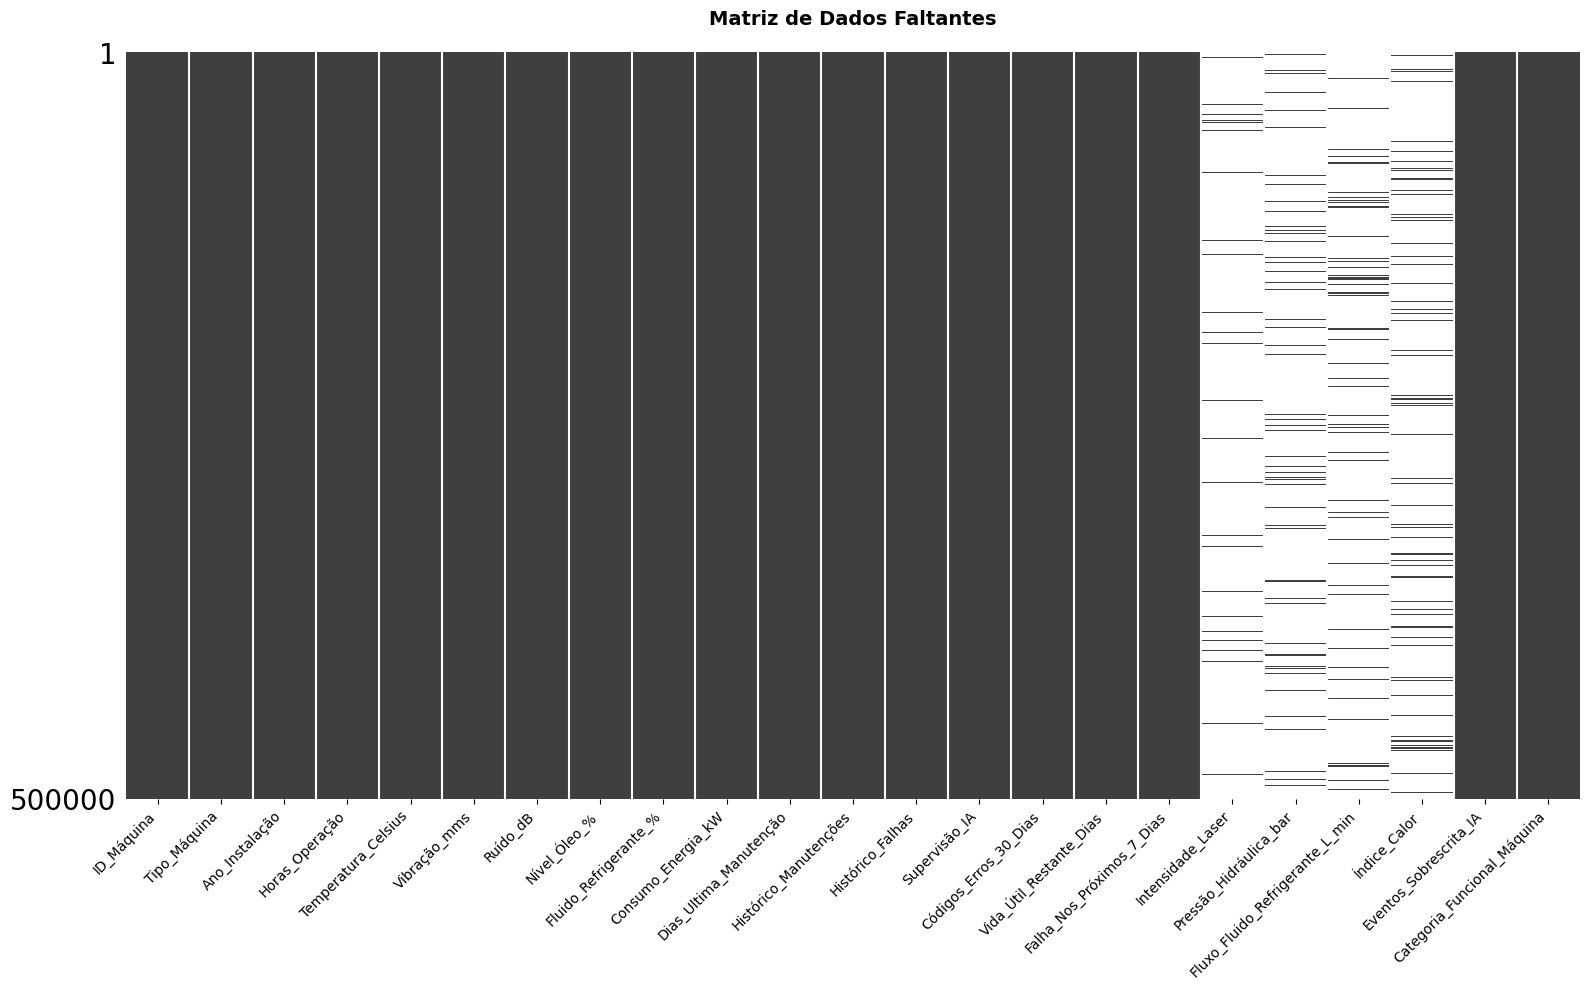

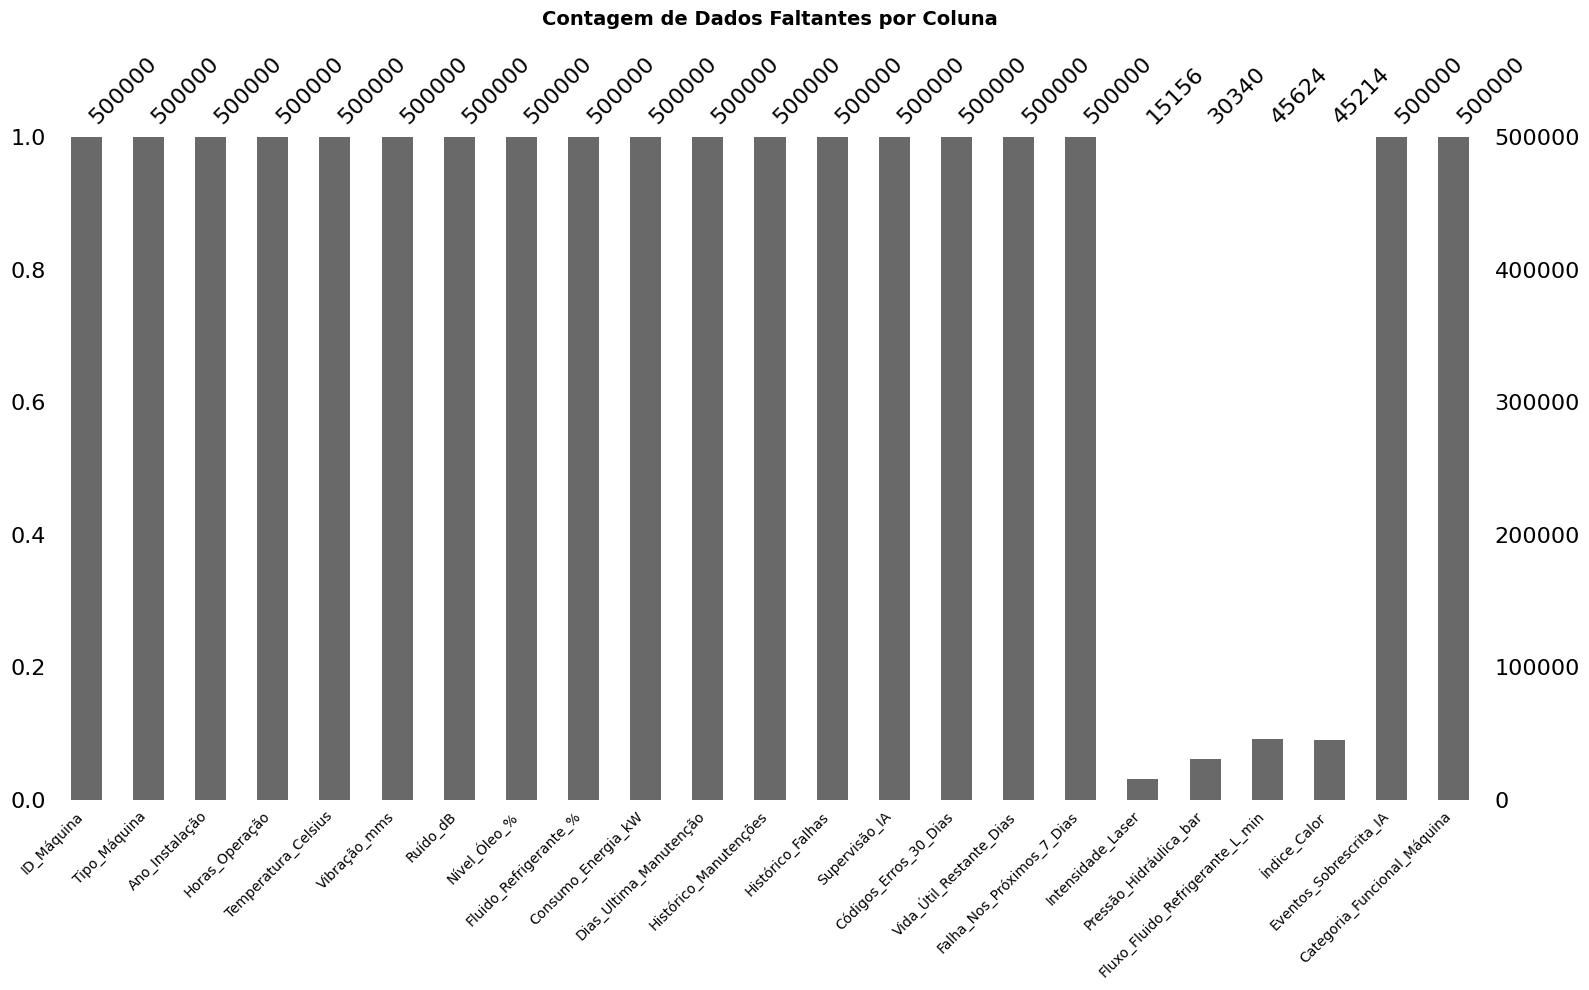



✓ Visualizações de dados faltantes geradas com sucesso


*******************************
Registros duplicados: 0


*******************************
Distribuição da variável target ("Falha_Nos_Próximos_7_Dias")
  "Não falha" (0): 93.99%
  "Falha" (1): 6.01%


(ID_Máquina                              0
 Tipo_Máquina                            0
 Ano_Instalação                          0
 Horas_Operação                          0
 Temperatura_Celsius                     0
 Vibração_mms                            0
 Ruído_dB                                0
 Nível_Óleo_%                            0
 Fluido_Refrigerante_%                   0
 Consumo_Energia_kW                      0
 Dias_Ultima_Manutenção                  0
 Histórico_Manutenções                   0
 Histórico_Falhas                        0
 Supervisão_IA                           0
 Códigos_Erros_30_Dias                   0
 Vida_Útil_Restante_Dias                 0
 Falha_Nos_Próximos_7_Dias               0
 Intensidade_Laser                  484844
 Pressão_Hidráulica_bar             469660
 Fluxo_Fluido_Refrigerante_L_min    454376
 Índice_Calor                       454786
 Eventos_Sobrescrita_IA                  0
 Categoria_Funcional_Máquina             0
 dtype: int

In [19]:
print('='*80)
ColoredConsole.print_colored("INICIANDO PIPELINE DE PRÉ-PROCESSAMENTO".center(80), 'cyan', None, 'bold')
print('='*80)

# Inicializar preprocessador, selecionando apresentação do dataset em Português
preprocessor = IoTDataPreprocessor(df_iot, language_en=False, language_ptbr=True)

# 1. Análise inicial dos dados do dataset
preprocessor.analyze_data_quality()



                TRATAMENTO DE VALORES MISSING                 
  Intensidade_Laser: preenchido com zero
  Pressão_Hidráulica_bar: preenchido com zero
  Fluxo_Fluido_Refrigerante_L_min: preenchido com zero
  Índice_Calor: preenchido com zero


VISUALIZAÇÕES DE DADOS FALTANTES (missingno):


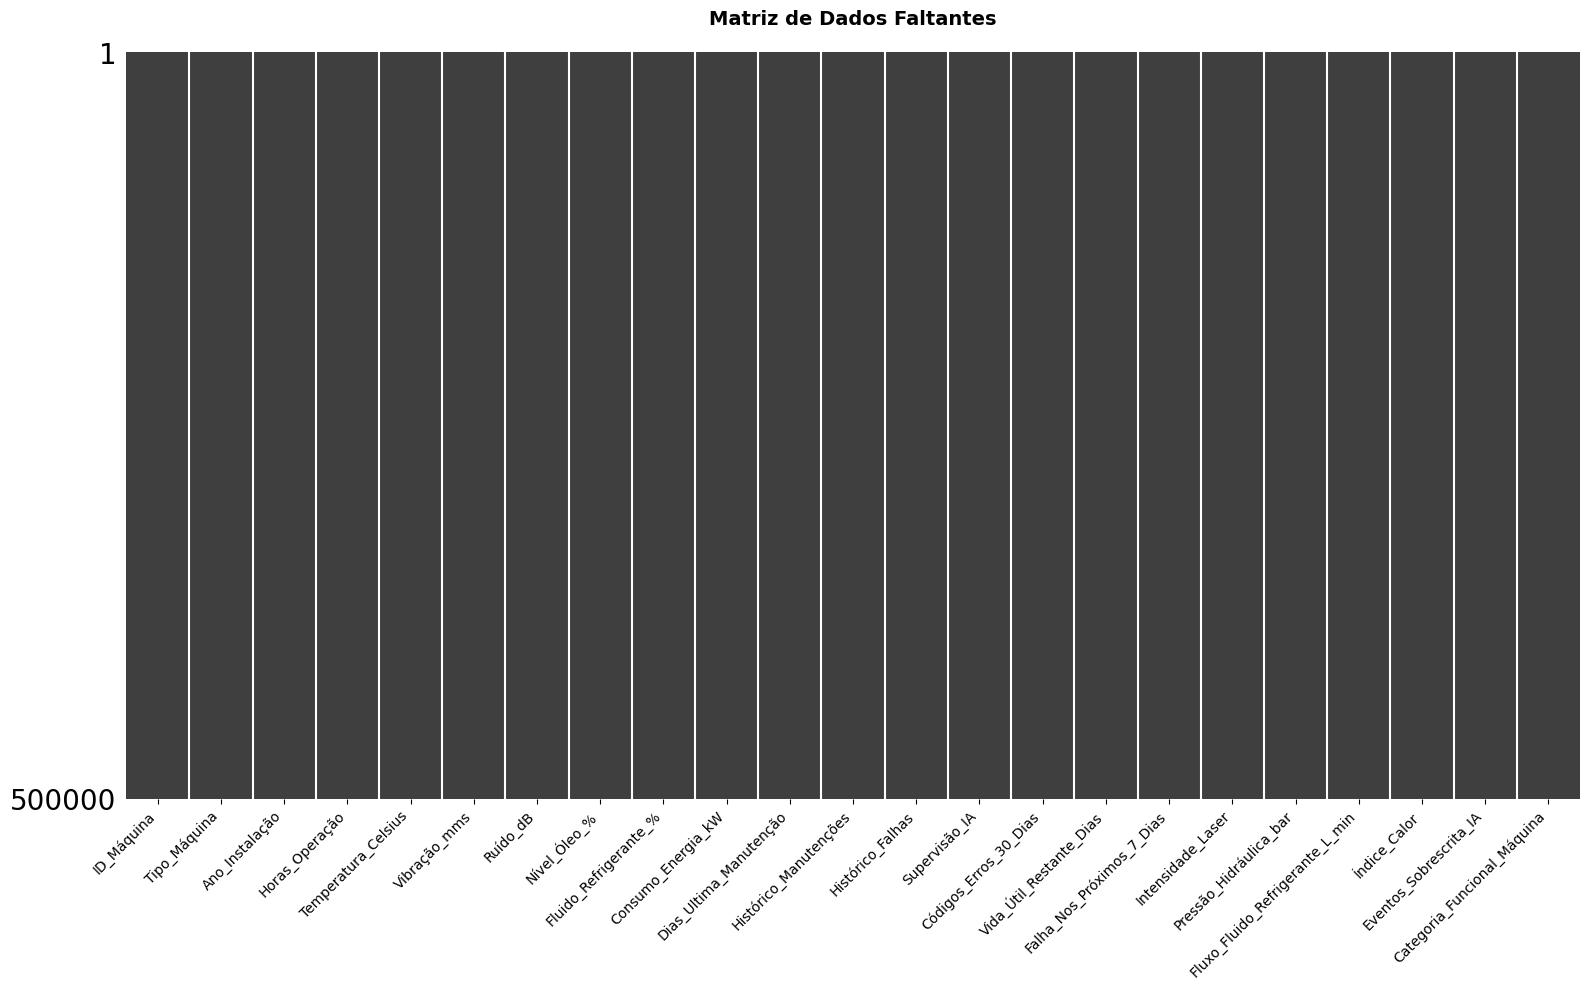

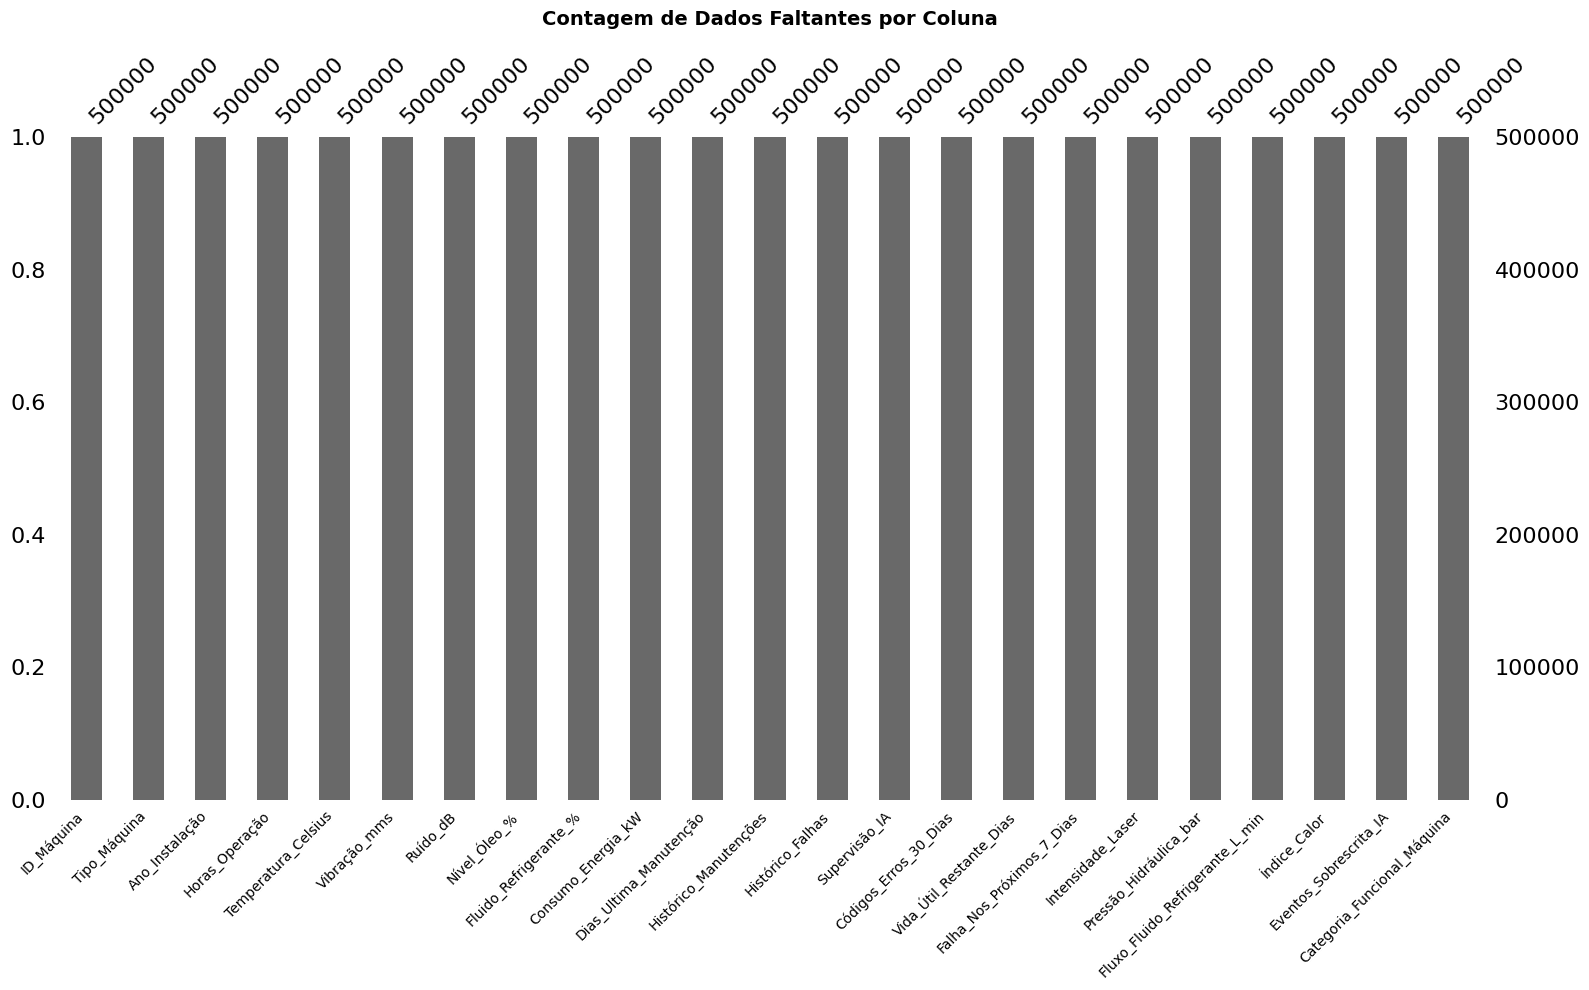



✓ Visualizações de dados faltantes geradas com sucesso


,ID_Máquina,Tipo_Máquina,Ano_Instalação,Horas_Operação,Temperatura_Celsius,Vibração_mms,Ruído_dB,Nível_Óleo_%,Fluido_Refrigerante_%,Consumo_Energia_kW,...,Supervisão_IA,Códigos_Erros_30_Dias,Vida_Útil_Restante_Dias,Falha_Nos_Próximos_7_Dias,Intensidade_Laser,Pressão_Hidráulica_bar,Fluxo_Fluido_Refrigerante_L_min,Índice_Calor,Eventos_Sobrescrita_IA,Categoria_Funcional_Máquina
0,MC_000000,Misturador,2027,81769,73.43,12.78,83.72,36.76,68.74,84.95,...,True,3,162.0,False,0.0,0.0,0.00,0.0,2,Processamento e Montagem
1,MC_000001,Chiller Industrial,2032,74966,58.32,14.99,77.04,100.00,62.13,154.61,...,True,4,147.0,False,0.0,0.0,40.92,0.0,2,Suporte e Utilitários
2,MC_000002,Máquina de Pegar e Colocar,2003,94006,49.63,23.78,69.08,42.96,35.96,51.90,...,True,6,0.0,True,0.0,0.0,0.00,0.0,2,Processamento e Montagem
3,MC_000003,Sistema de Visão,2007,76637,63.73,12.38,85.58,94.90,48.94,75.61,...,False,4,161.0,False,0.0,0.0,0.00,0.0,0,Inspeção e Qualidade
4,MC_000004,Sistema de Shuttle,2016,20870,42.77,4.42,96.72,47.56,53.78,224.93,...,False,1,765.0,False,0.0,0.0,0.00,0.0,0,Manuseio e Logística
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,MC_499995,Embaladora a Vácuo,2011,14425,65.42,16.50,81.95,59.21,73.67,255.87,...,False,0,820.0,False,0.0,0.0,0.00,0.0,0,Embalagem e Finalização
499996,MC_499996,Correia Transportadora / Esteira,2003,75501,44.83,12.88,64.94,73.69,29.25,198.37,...,False,4,34.0,False,0.0,0.0,0.00,0.0,0,Manuseio e Logística
499997,MC_499997,Máq. de Medição por Coordenadas,2039,19855,37.26,11.46,70.70,70.70,49.04,156.59,...,False,4,815.0,False,0.0,0.0,0.00,0.0,0,Inspeção e Qualidade
499998,MC_499998,Secador Industrial,2035,86823,67.72,16.76,77.45,97.00,15.40,132.33,...,True,0,99.0,False,0.0,0.0,0.00,0.0,2,Embalagem e Finalização


In [20]:
# 2. Tratar valores missing
preprocessor.handle_missing_values(strategy='zero')

In [21]:
# 3. Engenharia de features
#preprocessor.feature_engineering()